## NREL WIND Toolkit - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).  
Please consult the README file for setup instructions prior to running this notebook.


In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil

## Basic Usage

In [2]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5")  

In [3]:
list(f.attrs)  # list attributes belonging to the root group

['history']

In [4]:
f.attrs['history']   # attributes can be used to provide desriptions of the content

'Produced by 3TIER, Inc. under NREL subcontract AGV-2-22460-01'

## Datasets

In [5]:
# list the datasets in the file
for k in f:
    dset = f[k]
    print(f"{dset.name} {dset.shape}")

/DIF (61368, 1602, 2976)
/DNI (61368, 1602, 2976)
/GHI (61368, 1602, 2976)
/coordinates (1602, 2976)
/datetime (61368,)
/inversemoninobukhovlength_2m (61368, 1602, 2976)
/precipitationrate_0m (61368, 1602, 2976)
/pressure_0m (61368, 1602, 2976)
/pressure_100m (61368, 1602, 2976)
/pressure_200m (61368, 1602, 2976)
/relativehumidity_2m (61368, 1602, 2976)
/status (61368,)
/temperature_100m (61368, 1602, 2976)
/temperature_10m (61368, 1602, 2976)
/temperature_120m (61368, 1602, 2976)
/temperature_140m (61368, 1602, 2976)
/temperature_160m (61368, 1602, 2976)
/temperature_200m (61368, 1602, 2976)
/temperature_2m (61368, 1602, 2976)
/temperature_40m (61368, 1602, 2976)
/temperature_60m (61368, 1602, 2976)
/temperature_80m (61368, 1602, 2976)
/winddirection_100m (61368, 1602, 2976)
/winddirection_10m (61368, 1602, 2976)
/winddirection_120m (61368, 1602, 2976)
/winddirection_140m (61368, 1602, 2976)
/winddirection_160m (61368, 1602, 2976)
/winddirection_200m (61368, 1602, 2976)
/winddirection

In [6]:
# get reference to windspeed_100m dataset
dset = f['windspeed_100m']
dset.shape

(61368, 1602, 2976)

In [7]:
dset.dtype  # this property gives the type of the dataset (4-byte float in this case)

dtype('float32')

In [8]:
dset.shape[0] * dset.shape[1] * dset.shape[2] * 4 * 10**-12  # aprox 1 TB per dataset!

1.170300524544

In [9]:
# the chunks property show how the dataset values are internally stored - in tiles of this shape
dset.chunks

(24, 89, 186)

In [10]:
# approx 1.5 MB per chunk
dset.chunks[0] * dset.chunks[1] * dset.chunks[2] * 4 * 10**-6 

1.589184

## Time-slicing

Get the datetime index from the server and convert to a pandas dataframe for convenience:

In [11]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


Extract indexes for a particular span of time:

In [12]:
twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313,
       ...
       35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063],
      dtype='int64', length=8760)

Or a particular date:

In [13]:
timestep = dt.loc[dt.datetime == '2012-04-01 12:00:00'].index[0]
timestep

46020

## Map Data

In [14]:
%time data = dset[timestep,::8,::8]   # extract every 8th record at a particular time

CPU times: user 2.95 ms, sys: 461 μs, total: 3.41 ms
Wall time: 225 ms


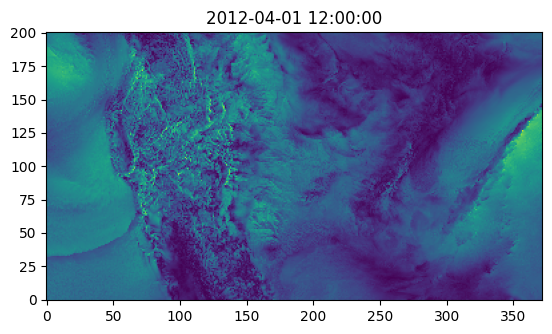

In [15]:
plt.title(str(dt.loc[timestep,"datetime"]))
plt.imshow(data, origin="lower")

In [16]:
%time data = dset[timestep,1100:1400,2000:2400]  # full-resolution subset

CPU times: user 1.01 ms, sys: 4.22 ms, total: 5.23 ms
Wall time: 21.2 ms


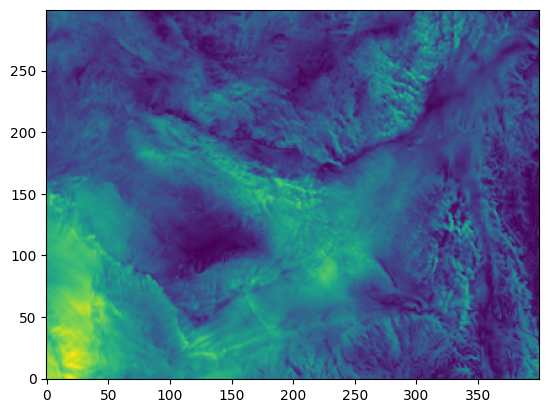

In [17]:
plt.imshow(data, origin="lower")

## Nearest Timeseries for given Lat/Lon

In [18]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

y,x indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 (40.709702, -73.992798)


In [19]:
# Get the entire 2010 timeseries data for a point in NYC
%time tseries = dset[min(twentyten):max(twentyten)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: user 5.57 ms, sys: 0 ns, total: 5.57 ms
Wall time: 7.09 s


In [20]:
len(tseries)   # 1 years * 365 days * 24 hours 

8760

Text(0.5, 1.0, 'NYC Windspeed in 2010')

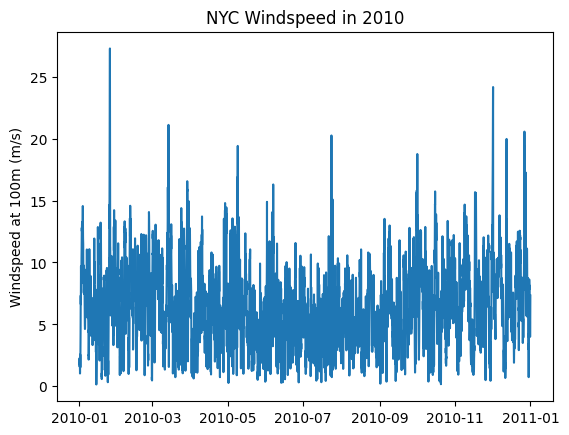

In [21]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("NYC Windspeed in 2010")

In [22]:
# Fetch full timeseries data for all seven years
LongsPeak_idx = indicesForCoord(f, 40.2549, -105.6160)
%time tseries = dset[:,LongsPeak_idx[0],LongsPeak_idx[1]]

CPU times: user 4.07 ms, sys: 0 ns, total: 4.07 ms
Wall time: 49.8 s


Text(0.5, 1.0, 'Longs Peak Windspeed 2007-2013')

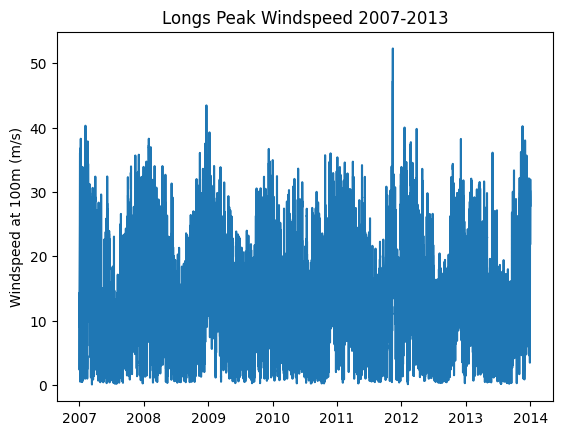

In [23]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Longs Peak Windspeed 2007-2013")

## Windspeed Statistics

In [24]:
dt["windspeed"] = tseries
dt["year"] = dt["datetime"].apply(lambda x: x.year)
dt["month"] = dt["datetime"].apply(lambda x: x.month)
dt["day"] = dt["datetime"].apply(lambda x: x.day)
dt["hour"] = dt["datetime"].apply(lambda x: x.hour)

In [25]:
agg = dt.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="windspeed")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,17.782742,17.781574,17.936459,17.981829,17.954967,18.106070,18.217440,18.367191,18.447174,18.534664,...,18.363831,18.178539,17.854143,17.431707,17.194565,17.027246,16.904301,16.998865,17.139912,17.422819
2,16.437485,16.639477,16.689278,16.629135,16.662443,16.965654,17.273306,17.460009,17.616871,17.667582,...,17.730576,17.413105,17.092430,16.651268,16.390568,16.220217,16.195866,16.077782,16.211063,16.287605
3,14.604920,15.130107,15.412606,15.489409,15.776676,16.043848,16.277828,16.474186,16.677057,16.629452,...,16.498095,16.084057,15.284851,14.944520,14.798257,14.730160,14.745756,14.960455,14.894045,14.823628
4,13.538097,13.942963,14.095672,14.382008,14.624935,14.589562,14.894792,15.148314,15.371621,15.806625,...,15.633238,14.803759,14.014666,13.467426,13.230791,13.364985,13.376946,13.591708,13.539725,13.335716
5,11.307108,11.303394,11.524437,11.436130,11.292299,11.719445,11.939953,11.890996,12.257992,12.596297,...,12.245151,11.770721,11.352464,11.030234,11.190969,11.271288,11.059191,11.392616,11.504339,11.454046
6,12.146861,11.924527,11.722508,11.499505,11.589317,11.590261,11.332961,11.392022,11.676019,12.099078,...,11.952153,11.572067,11.499331,11.411350,11.469437,11.594026,11.791553,12.379776,12.270243,12.375328
7,7.504178,7.493124,7.438204,7.311883,7.368392,7.312094,7.841231,7.848489,7.851456,8.082863,...,8.146431,7.786299,7.660075,7.651398,7.561840,7.867813,8.126966,8.486354,7.907937,7.684139
8,8.010785,8.004921,7.972166,7.861540,7.758930,8.114224,8.464076,8.491234,8.781244,9.044336,...,9.444620,9.003101,8.690378,8.655359,8.424557,8.409269,8.399918,8.803268,8.915976,8.636556
9,9.860007,9.619100,9.669471,10.028004,10.206233,10.343493,10.769066,11.195759,11.499840,11.649381,...,11.362492,10.789354,10.624351,10.473778,10.323613,10.251211,10.327232,10.510371,10.489647,10.150558


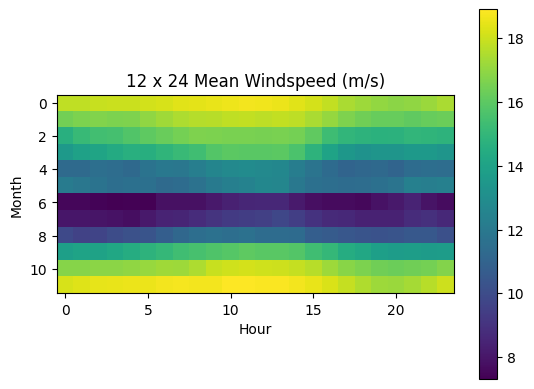

In [26]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean Windspeed (m/s)")
plt.colorbar()